In [57]:
import sys
sys.path.append('../code/')

from tqdm import tqdm

# import warnings
# warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import pacf, acf
from arch import arch_model

from preprocessing_utils import preprocess_df
from plot_utils import plot_store_charts, plot_folds
from test_utils import run_stat_test
from sm_utils import compute_pacf_acf, StatmodelsWrapper, run_k_fold_tain_val_statmodels
from metrics import mean_absolute_error, rmse, rss, r2_score, durbin_watson

%matplotlib inline

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

# Load Data

In [2]:
ts = pd.read_csv('../data/US1.NVDA_200101_210215.csv', delimiter=';')
ts = preprocess_df(ts)
ts

,ticker,per,date,time,open,high,low,close,vol,Nclose
0,US1.NVDA,D,2020-01-02,0,238.85,239.88,236.73,239.79,303428,0.392886
1,US1.NVDA,D,2020-01-03,0,234.65,237.81,234.17,236.37,268936,0.387282
2,US1.NVDA,D,2020-01-06,0,232.21,237.25,231.52,237.07,432624,0.388429
3,US1.NVDA,D,2020-01-07,0,238.03,241.76,236.39,239.83,576787,0.392951
4,US1.NVDA,D,2020-01-08,0,239.65,242.04,238.15,240.42,540373,0.393918
...,...,...,...,...,...,...,...,...,...,...
275,US1.NVDA,D,2021-02-08,0,549.96,578.93,549.96,577.70,316219,0.946537
276,US1.NVDA,D,2021-02-09,0,574.02,583.00,568.90,570.35,142242,0.934494
277,US1.NVDA,D,2021-02-10,0,579.02,596.20,574.45,590.72,320581,0.967870
278,US1.NVDA,D,2021-02-11,0,599.50,610.89,597.61,610.33,268265,1.000000


# Train/Test splitting

In [3]:
test_file_period = 7
train_file_period = ts['date'].max() - ts['date'].min()
print(f"Test file period {test_file_period}\nTrain file period {train_file_period}")

Test file period 7
Train file period 407 days 00:00:00


In [4]:
fold_ids = list(TimeSeriesSplit(test_size=test_file_period).split(ts))

# Trim start in order to have same size folds
train_fold_len = min([len(el[0]) for el in fold_ids])
for i in range(len(fold_ids)):
    fold_ids[i] = (fold_ids[i][0][-train_fold_len:], fold_ids[i][1])

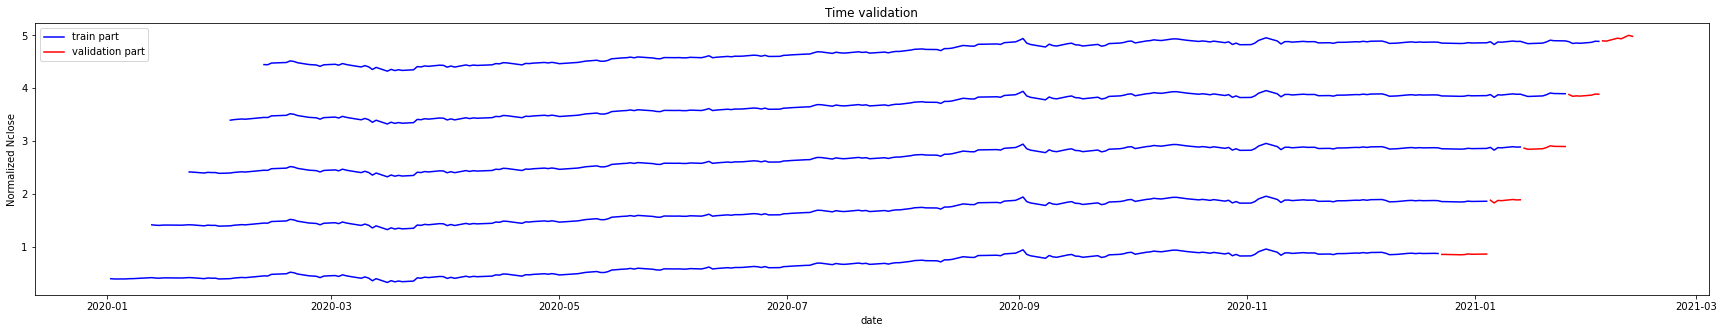

In [5]:
plot_folds(ts, fold_ids)

# Modelling

In [6]:
def compute_metrics(y_pred, y_true):
    print('RMSE: %.4f'% np.sqrt(sum((y_pred-y_true)**2)/len(y_true)))
    print('RSS: %.4f'% sum((y_pred-y_true.values)**2))
    print ('r2_score: %.4f' %r2_score(y_true, y_pred))
    print ('durbin_watson score: %.4f' %durbin_watson(np.abs(y_pred - y_true)))
    
def dima_reversed_partial(time_s, preds):
    time_s = np.log1p(time_s)
    time_s_diff_1 = time_s.diff(1).dropna()
    time_s_diff_1_from_pred = time_s_diff_1.shift(1).dropna() + preds
    log_result = time_s.shift(1).dropna()+ time_s_diff_1_from_pred
    return np.expm1(log_result).dropna()

def dima_stationary(input):
    return np.log1p(input).diff(1).dropna().diff(1).dropna().reset_index(drop=True)

In [7]:
y_true_all = dima_stationary(ts['close'])
# y_true = dima_stationary(train_fold_1['close'])

y_true = y_true_all.iloc[:-7]
y_tru_val = y_true_all.iloc[-7:]

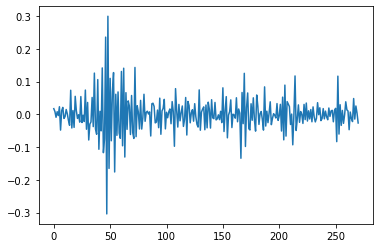

In [8]:
plt.plot(y_true)

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


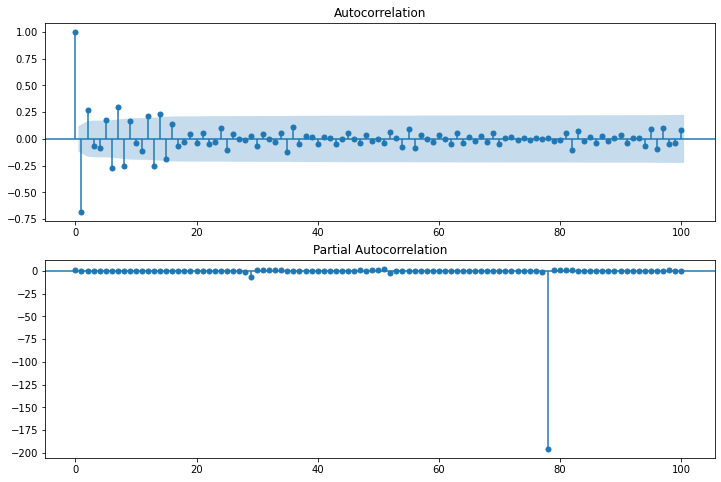

In [9]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_true, lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_true, lags=100, ax=ax2)
plt.show()

In [10]:
ARIMA_m = ARIMA(y_true, order=(40,0,0))

ARIMA_m = ARIMA_m.fit()

In [11]:
ARIMA_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                  271
Model:                ARIMA(40, 0, 0)   Log Likelihood                 551.662
Date:                Mon, 22 Mar 2021   AIC                          -1019.324
Time:                        12:17:31   BIC                           -868.035
Sample:                             0   HQIC                          -958.580
                                - 271                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.085e-05   8.24e-05     -0.253      0.800      -0.000       0.000
ar.L1         -1.2440      0.057    -21.774      0.000      -1.356      -1.132
ar.L2         -1.1492      0.088    -12.987      0.000      -1.323      -0.976
ar.L3         -1.0851      0.112     -9.686      0.000      -1.305      -0.866
ar.L4         -1.1355      0.129     -8.771      0.000      -1.389      -0.882
ar.L5         -1.1601      0.155     -7.479      0.000      -1.464      -0.856
ar.L6         -1.2798      0.178     -7.182      0.000      -1.629      -0.931
ar.L7         -1.1712      0.201     -5.828      0.000      -1.565      -0.777
ar.L8         -1.1628      0.216     -5.380      0.000      -1.586      -0.739
ar.L9         -1.0514      0.225     -4.665      0.000      -1.493      -0.610
ar.L10        -1.0188      0.232     -4.385      0.000      -1.474      -0.563
ar.L11        -1.0627      0.232     -4.588      0.000      -1.517      -0.609
ar.L12        -0.9892      0.244     -4.060      0.000      -1.467      -0.512
ar.L13        -1.0027      0.232     -4.331      0.000      -1.457      -0.549
ar.L14        -0.8949      0.236     -3.799      0.000      -1.357      -0.433
ar.L15        -0.8712      0.242     -3.607      0.000      -1.345      -0.398
ar.L16        -0.7827      0.249     -3.146      0.002      -1.270      -0.295
ar.L17        -0.8289      0.272     -3.042      0.002      -1.363      -0.295
ar.L18        -0.8569      0.276     -3.102      0.002      -1.398      -0.315
ar.L19        -0.8844      0.267     -3.308      0.001      -1.408      -0.360
ar.L20        -0.7976      0.268     -2.977      0.003      -1.323      -0.272
ar.L21        -0.8172      0.268     -3.053      0.002      -1.342      -0.293
ar.L22        -0.8727      0.270     -3.238      0.001      -1.401      -0.344
ar.L23        -0.9345      0.281     -3.329      0.001      -1.485      -0.384
ar.L24        -0.8345      0.293     -2.844      0.004      -1.410      -0.259
ar.L25        -0.8198      0.303     -2.708      0.007      -1.413      -0.226
ar.L26        -0.7511      0.308     -2.441      0.015      -1.354      -0.148
ar.L27        -0.6313      0.313     -2.018      0.044      -1.245      -0.018
ar.L28        -0.5551      0.328     -1.693      0.090      -1.198       0.087
ar.L29        -0.4983      0.319     -1.560      0.119      -1.124       0.128
ar.L30        -0.4717      0.302     -1.560      0.119      -1.064       0.121
ar.L31        -0.3449      0.304     -1.133      0.257      -0.941       0.252
ar.L32        -0.1937      0.294     -0.659      0.510      -0.770       0.382
ar.L33        -0.1201      0.269     -0.446      0.655      -0.648       0.408
ar.L34        -0.1256      0.251     -0.500      0.617      -0.618       0.366
ar.L35        -0.1934      0.229     -0.843      0.399      -0.643       0.256
ar.L36        -0.1262      0.204     -0.620      0.535      -0.525       0.273
ar.L37         0.0533      0.168      0.317      0.751      -0.276       0.383
ar

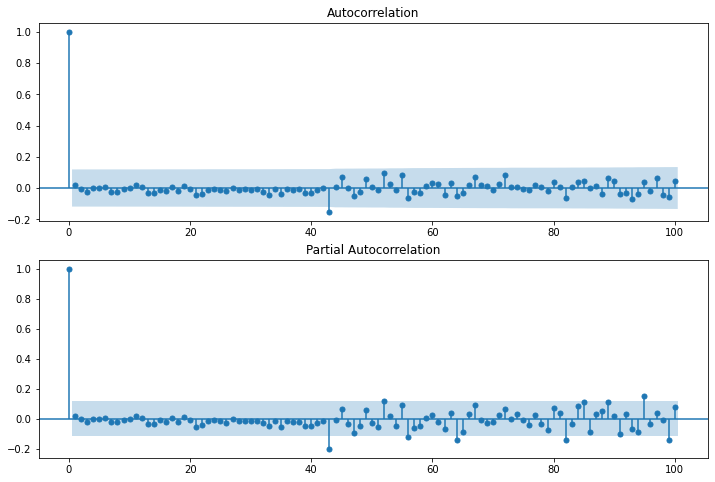

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ARIMA_m.resid, lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ARIMA_m.resid, lags=100, ax=ax2)
plt.show()

In [13]:
ARIMA_m = ARIMA(y_true, order=(40,0,44))

ARIMA_m = ARIMA_m.fit()

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


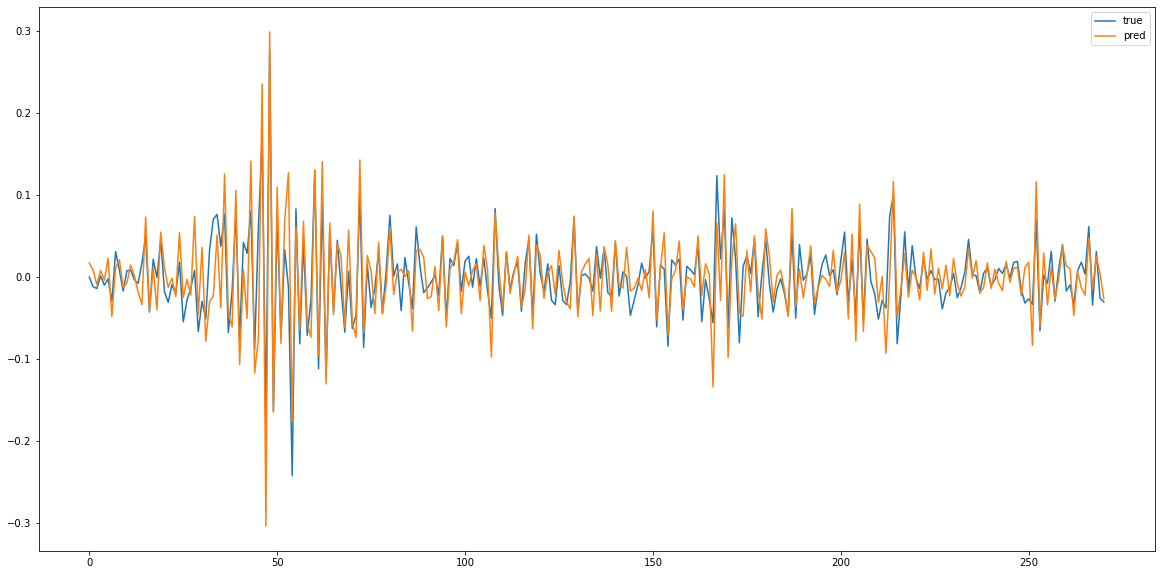

RMSE: 0.0309
RSS: 0.2581
r2_score: 0.7139
durbin_watson score: 0.6256


In [14]:
plt.figure(figsize=(20,10))
plt.plot(ARIMA_m.fittedvalues, label='true')
plt.plot(y_true, label='pred')
plt.legend()
plt.show()

compute_metrics(ARIMA_m.fittedvalues, y_true)

In [15]:
arima_pred = ARIMA_m.fittedvalues
arima_res = ARIMA_m.resid

In [16]:
arima_pred

0     -0.000021
1     -0.011722
2     -0.013951
3      0.001323
4     -0.009875
         ...   
266    0.061774
267   -0.034146
268    0.031205
269   -0.025834
270   -0.030356
Length: 271, dtype: float64

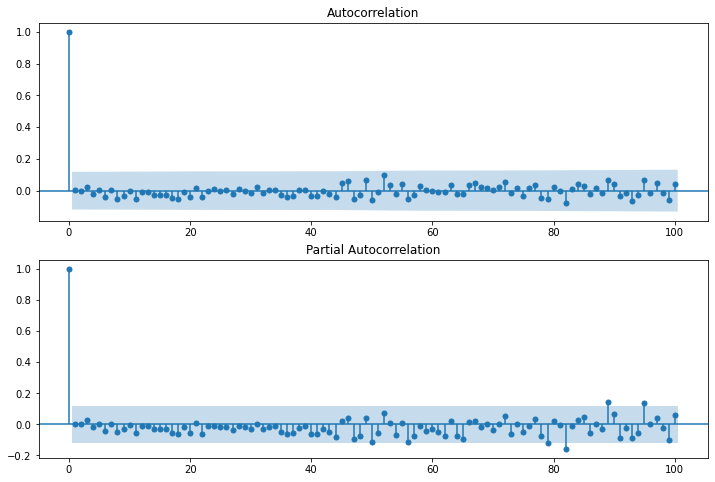

In [39]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_res, lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_res, lags=100, ax=ax2)
plt.show()

In [40]:
arch_m = arch_model(arima_res, mean='HARX', lags=90, vol='ARCH', p=32) 
arch_m = arch_m.fit(update_freq=0)
arch_m.summary()

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003586. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully    (Exit mode 0)
            Current function value: -470.41521975688534
            Iterations: 19
            Function evaluations: 1920
            Gradient evaluations: 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                           HAR - ARCH Model Results                           
==============================================================================
Dep. Variable:                   None   R-squared:                       0.387
Mean Model:                       HAR   Adj. R-squared:                 -0.226
Vol Model:                       ARCH   Log-Likelihood:                470.415
Distribution:                  Normal   AIC:                          -692.830
Method:            Maximum Likelihood   BIC:                          -296.217
                                        No. Observations:                  181
Date:                Mon, Mar 22 2021   Df Residuals:                       90
Time:                        12:39:42   Df Model:                           91
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const      -8.4438e-04  3.055e-03     -0.276      0.782 [-6.831e-03,5.143e-03]
None[0:1]       0.3127      0.381      0.821      0.412      [ -0.434,  1.059]
None[0:2]      -0.3644      0.673     -0.542      0.588      [ -1.683,  0.954]
None[0:3]       0.1059      0.802      0.132      0.895      [ -1.465,  1.677]
None[0:4]      -0.7877      0.775     -1.016      0.310      [ -2.308,  0.732]
None[0:5]       0.0608      0.975  6.242e-02      0.950      [ -1.849,  1.971]
None[0:6]       0.8450      1.189      0.710      0.477      [ -1.486,  3.176]
None[0:7]      -1.7773      2.010     -0.884      0.376      [ -5.716,  2.162]
None[0:8]       2.0152      1.906      1.057      0.290      [ -1.721,  5.751]
None[0:9]      -0.5565      1.543     -0.361      0.718      [ -3.580,  2.467]
None[0:10]     -0.2598      1.008     -0.258      0.797      [ -2.235,  1.715]
None[0:11]      0.3249      4.253  7.640e-02      0.939      [ -8.011,  8.661]
None[0:12]      0.3935      4.402  8.938e-02      0.929      [ -8.235,  9.022]
None[0:13]      2.5219      3.192      0.790      0.430      [ -3.735,  8.778]
None[0:14]     -2.8462      4.143     -0.687      0.492      [-10.966,  5.273]
None[0:15]      2.5132      3.574      0.703      0.482      [ -4.491,  9.517]
None[0:16]     -1.7038      5.372     -0.317      0.751      [-12.232,  8.824]
None[0:17]      0.5629      2.907      0.194      0.846      [ -5.134,  6.260]
None[0:18]     -2.9645      4.164     -0.712      0.477      [-11.126,  5.197]
None[0:19]     -0.8617      4.839     -0.178      0.859      [-10.347,  8.623]
None[0:20]     -0.4632      3.897     -0.119      0.905      [ -8.102,  7.175]
None[0:21]      0.6904      5.140      0.134      0.893      [ -9.385, 10.766]
None[0:22]      0.5699      5.944  9.586e-02      0.924      [-11.081, 12.221]
None[0:23]      2.4490      5.214      0.470      0.639      [ -7.770, 12.669]
None[0:24]     -2.5350      8.361     -0.303      0.762      [-18.923, 13.853]
None[0:25]      4.2611      9.542      0.447      0.655      [-14.441, 22.963]
None[0:26]     -3.2374     10.336     -0.313      0.754      [-23.496, 17.021]
None[0:27]      1.5388      7.712      0.200      0.842      [-13.576, 16.654]
None[0:28]     -0.3950      8.470 -4.664e-02      0.963      [-16.996, 16.206]
None[0:29]     -3.6488     14.319     -0.255      0.799      [-31.713, 24.416]
None[0:30]      5.5106     16.750      0.329      0.742      [-27.320, 38.341]
None[0:31]     -2.1550     10.415     -0.207      0.836      [-22.568, 18.258]
None[0:32]     -0.3259      7.552 -4.315e-02      0.966      [-15.128, 14.477]
None[0:33]     -5.0603      5.716     -0.885      0.376      [-16.263,  6.143]
None[0:34]      6.5546      7.551      0.868      0.385      [ -8.244, 21.354]
None[0:35]     -5.9928      9.680     -0.619      0.536      [-24.964, 12.979]
No

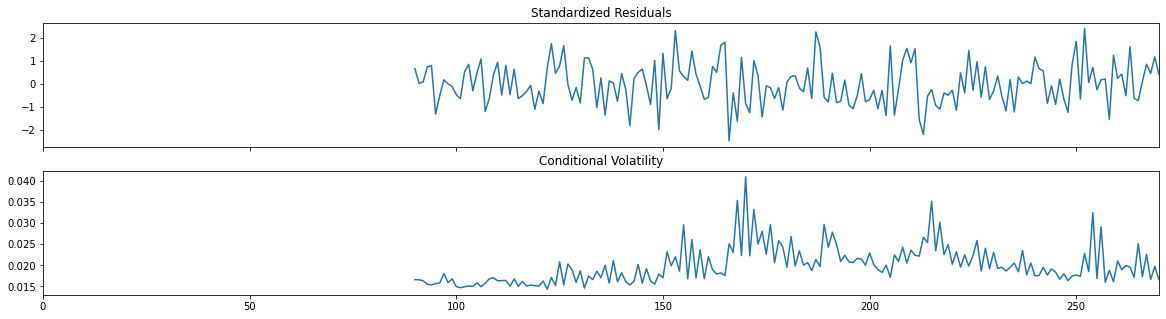

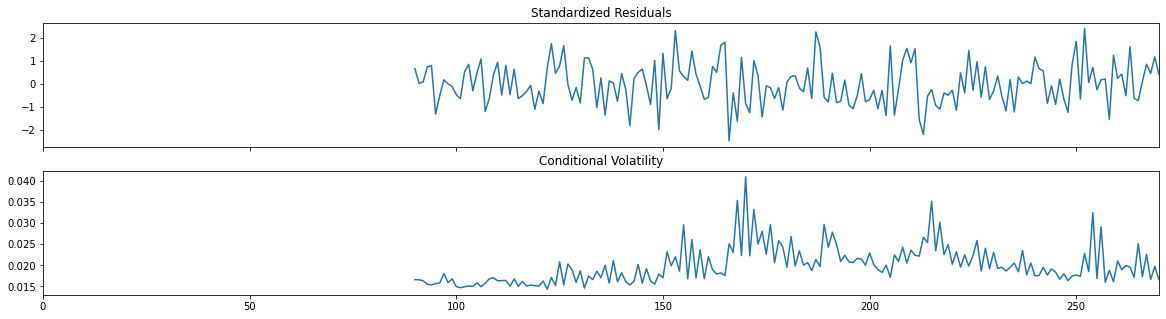

In [41]:
arch_m.plot()

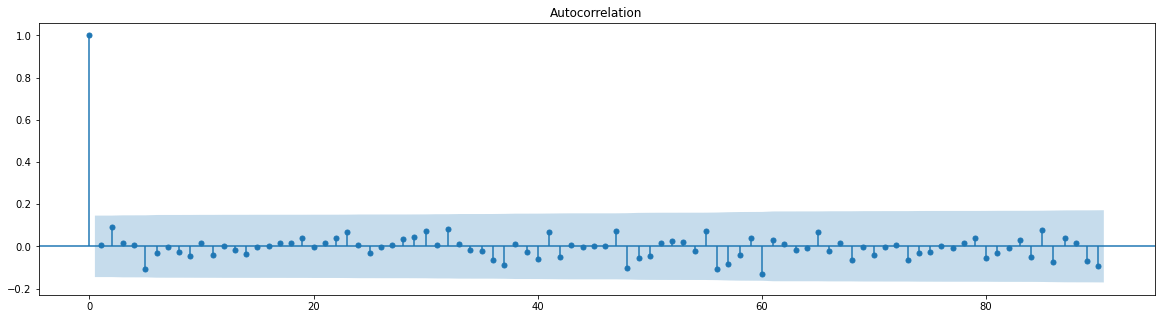

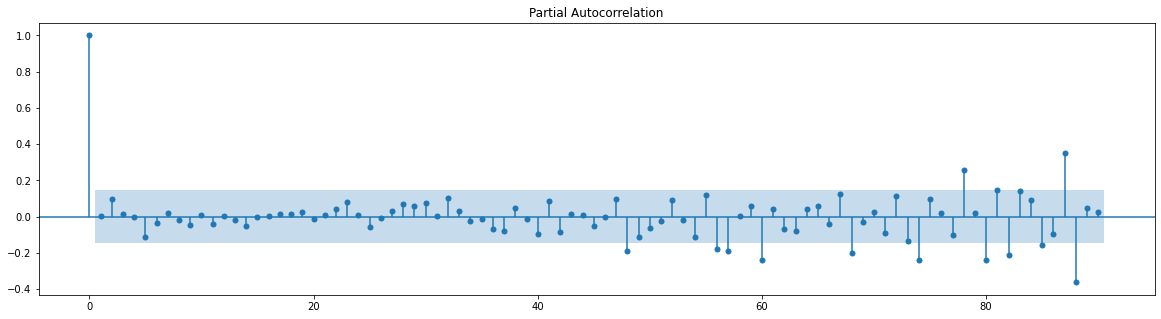

In [42]:
fig1 = sm.graphics.tsa.plot_acf(arch_m.resid.dropna().values, lags=90)
fig2 = sm.graphics.tsa.plot_pacf(arch_m.resid.dropna().values, lags=90)
plt.show()

In [43]:
garch_m = arch_model(arima_res, mean='HARX', lags=90, vol='GARCH', p=20, q=1)
garch_m = garch_m.fit(update_freq=0)
garch_m.summary()

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003586. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully    (Exit mode 0)
            Current function value: -464.28255420291316
            Iterations: 11
            Function evaluations: 834
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          HAR - GARCH Model Results                           
==============================================================================
Dep. Variable:                   None   R-squared:                       0.404
Mean Model:                       HAR   Adj. R-squared:                 -0.192
Vol Model:                      GARCH   Log-Likelihood:                464.283
Distribution:                  Normal   AIC:                          -702.565
Method:            Maximum Likelihood   BIC:                          -341.135
                                        No. Observations:                  181
Date:                Mon, Mar 22 2021   Df Residuals:                       90
Time:                        12:40:10   Df Model:                           91
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const      -1.4990e-03  3.456e-03     -0.434      0.664 [-8.272e-03,5.274e-03]
None[0:1]       0.2279      0.198      1.149      0.251      [ -0.161,  0.617]
None[0:2]      -0.2034      0.275     -0.741      0.459      [ -0.742,  0.335]
None[0:3]       0.0735      0.746  9.860e-02      0.921      [ -1.388,  1.535]
None[0:4]      -0.5195      1.436     -0.362      0.718      [ -3.334,  2.295]
None[0:5]      -0.0486      1.210 -4.015e-02      0.968      [ -2.420,  2.323]
None[0:6]       0.6597      1.658      0.398      0.691      [ -2.589,  3.908]
None[0:7]      -1.4541      0.874     -1.664  9.604e-02      [ -3.167,  0.258]
None[0:8]       1.8480      1.846      1.001      0.317      [ -1.771,  5.467]
None[0:9]      -0.8132      1.702     -0.478      0.633      [ -4.150,  2.523]
None[0:10]     -0.1436      0.996     -0.144      0.885      [ -2.095,  1.808]
None[0:11]      0.2210      3.115  7.092e-02      0.943      [ -5.885,  6.327]
None[0:12]      0.3875      1.946      0.199      0.842      [ -3.427,  4.202]
None[0:13]      2.7007      5.238      0.516      0.606      [ -7.565, 12.966]
None[0:14]     -3.0292      2.077     -1.458      0.145      [ -7.101,  1.042]
None[0:15]      2.4408      7.862      0.310      0.756      [-12.969, 17.850]
None[0:16]     -1.5505      9.423     -0.165      0.869      [-20.020, 16.919]
None[0:17]      0.2835      2.516      0.113      0.910      [ -4.648,  5.214]
None[0:18]     -3.0170      3.979     -0.758      0.448      [-10.816,  4.782]
None[0:19]     -0.4260      5.768 -7.386e-02      0.941      [-11.731, 10.879]
None[0:20]     -0.4655      3.036     -0.153      0.878      [ -6.416,  5.485]
None[0:21]      0.4888      5.493  8.898e-02      0.929      [-10.278, 11.256]
None[0:22]      0.4778      7.996  5.976e-02      0.952      [-15.193, 16.149]
None[0:23]      2.3733      6.968      0.341      0.733      [-11.284, 16.030]
None[0:24]     -2.5539      9.105     -0.281      0.779      [-20.398, 15.291]
None[0:25]      4.1917      5.266      0.796      0.426      [ -6.129, 14.513]
None[0:26]     -3.3037      4.366     -0.757      0.449      [-11.861,  5.254]
None[0:27]      1.4579      6.529      0.223      0.823      [-11.339, 14.255]
None[0:28]     -0.4691      3.792     -0.124      0.902      [ -7.901,  6.962]
None[0:29]     -3.7273     13.508     -0.276      0.783      [-30.203, 22.749]
None[0:30]      5.5149      7.966      0.692      0.489      [-10.099, 21.129]
None[0:31]     -2.1951      6.494     -0.338      0.735      [-14.924, 10.533]
None[0:32]     -0.2921      5.847 -4.996e-02      0.960      [-11.751, 11.167]
None[0:33]     -4.9760      3.662     -1.359      0.174      [-12.154,  2.202]
None[0:34]      6.7541     19.612      0.344      0.731      [-31.685, 45.193]
None[0:35]     -5.8028      7.603     -0.763      0.445      [-20.705,  9.100]
No

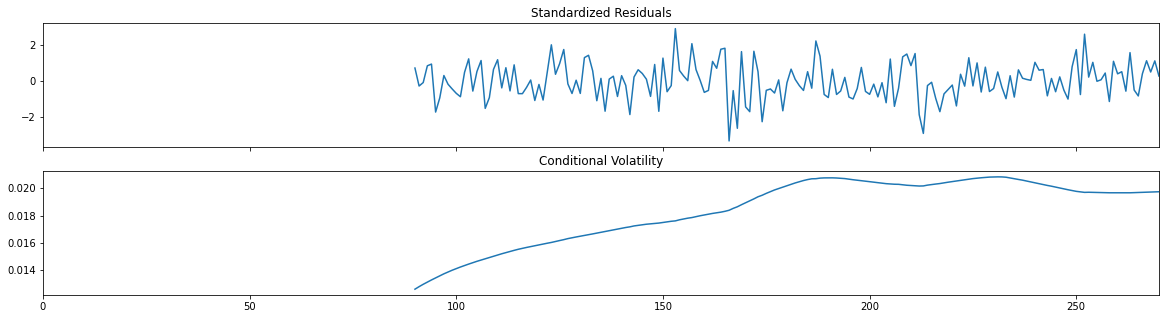

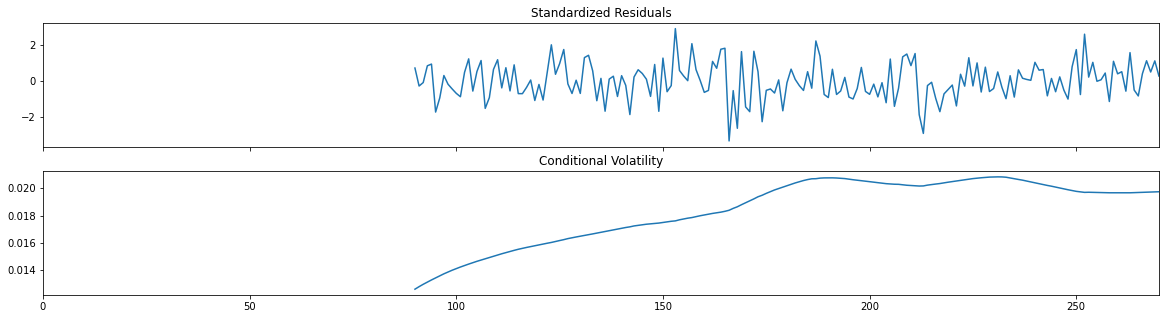

In [44]:
garch_m.plot()

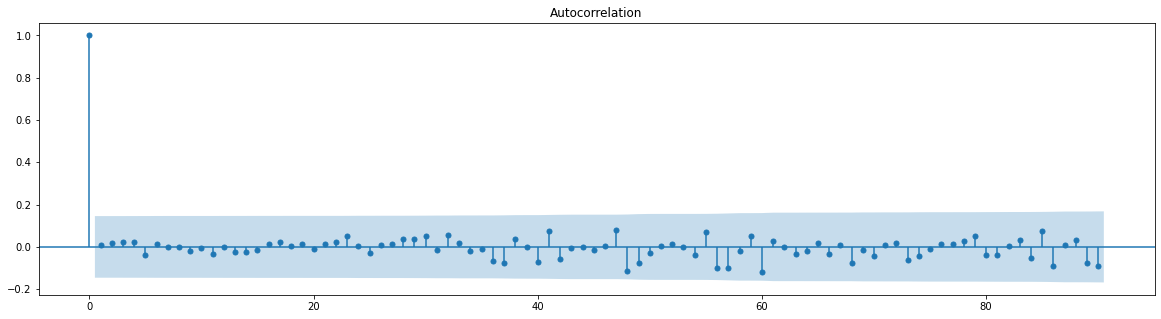

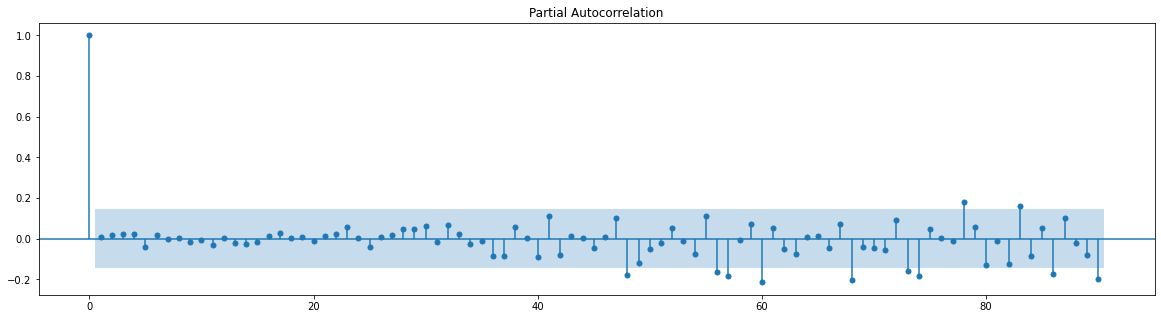

In [45]:
fig1 = sm.graphics.tsa.plot_acf(garch_m.resid.dropna().values.squeeze(), lags=90)
fig2 = sm.graphics.tsa.plot_pacf(garch_m.resid.dropna().values.squeeze(), lags=90)
plt.show()

In [46]:
figarch_m = arch_model(arima_res, mean='HARX', lags=90, vol='FIGARCH', p=1, q=1)
figarch_m = figarch_m.fit(update_freq=0)
figarch_m.summary()

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003586. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully    (Exit mode 0)
            Current function value: -495.9645484800693
            Iterations: 28
            Function evaluations: 2350
            Gradient evaluations: 24


<class 'statsmodels.iolib.summary.Summary'>
"""
                         HAR - FIGARCH Model Results                          
==============================================================================
Dep. Variable:                   None   R-squared:                       0.184
Mean Model:                       HAR   Adj. R-squared:                 -0.633
Vol Model:                    FIGARCH   Log-Likelihood:                495.965
Distribution:                  Normal   AIC:                          -801.929
Method:            Maximum Likelihood   BIC:                          -498.072
                                        No. Observations:                  181
Date:                Mon, Mar 22 2021   Df Residuals:                       90
Time:                        12:40:33   Df Model:                           91
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const      -1.8737e-03  4.586e-03     -0.409      0.683 [-1.086e-02,7.116e-03]
None[0:1]       0.2187      0.675      0.324      0.746      [ -1.104,  1.541]
None[0:2]      -0.2018      1.432     -0.141      0.888      [ -3.009,  2.606]
None[0:3]       0.0143      2.248  6.363e-03      0.995      [ -4.391,  4.420]
None[0:4]      -0.1998      2.368 -8.438e-02      0.933      [ -4.841,  4.442]
None[0:5]      -0.3806      1.156     -0.329      0.742      [ -2.646,  1.885]
None[0:6]       1.6319      1.534      1.064      0.287      [ -1.375,  4.638]
None[0:7]      -2.7324      1.333     -2.050  4.041e-02      [ -5.345, -0.119]
None[0:8]       1.6292      2.364      0.689      0.491      [ -3.005,  6.263]
None[0:9]       0.1164      1.624  7.170e-02      0.943      [ -3.066,  3.299]
None[0:10]     -0.6421      3.583     -0.179      0.858      [ -7.664,  6.380]
None[0:11]      0.9447      2.810      0.336      0.737      [ -4.562,  6.452]
None[0:12]     -0.0460      4.923 -9.346e-03      0.993      [ -9.696,  9.604]
None[0:13]      1.1482      1.886      0.609      0.543      [ -2.549,  4.846]
None[0:14]     -1.0854      2.384     -0.455      0.649      [ -5.757,  3.586]
None[0:15]      2.4209      2.995      0.808      0.419      [ -3.449,  8.291]
None[0:16]     -2.2985      9.780     -0.235      0.814      [-21.467, 16.870]
None[0:17]      0.7586     11.788  6.435e-02      0.949      [-22.346, 23.864]
None[0:18]     -0.9932     13.136 -7.561e-02      0.940      [-26.739, 24.752]
None[0:19]     -5.1483     16.891     -0.305      0.761      [-38.253, 27.957]
None[0:20]      0.5530     12.213  4.528e-02      0.964      [-23.384, 24.490]
None[0:21]      2.2857     11.984      0.191      0.849      [-21.202, 25.774]
None[0:22]      1.5027      8.172      0.184      0.854      [-14.514, 17.519]
None[0:23]      2.7172      8.499      0.320      0.749      [-13.941, 19.376]
None[0:24]     -3.9527     12.108     -0.326      0.744      [-27.683, 19.778]
None[0:25]      4.4706      8.472      0.528      0.598      [-12.135, 21.076]
None[0:26]     -4.1036      9.840     -0.417      0.677      [-23.390, 15.183]
None[0:27]      2.1598      8.645      0.250      0.803      [-14.784, 19.104]
None[0:28]     -2.2150      6.478     -0.342      0.732      [-14.912, 10.482]
None[0:29]     -1.7969      8.046     -0.223      0.823      [-17.566, 13.972]
None[0:30]      4.5517      8.570      0.531      0.595      [-12.245, 21.348]
None[0:31]     -2.2946      8.528     -0.269      0.788      [-19.009, 14.420]
None[0:32]     -0.2643     22.226 -1.189e-02      0.991      [-43.827, 43.298]
None[0:33]     -4.7287     26.577     -0.178      0.859      [-56.820, 47.362]
None[0:34]      4.3333     19.099      0.227      0.821      [-33.100, 41.766]
None[0:35]     -4.5637     13.054     -0.350      0.727      [-30.150, 21.022]
No

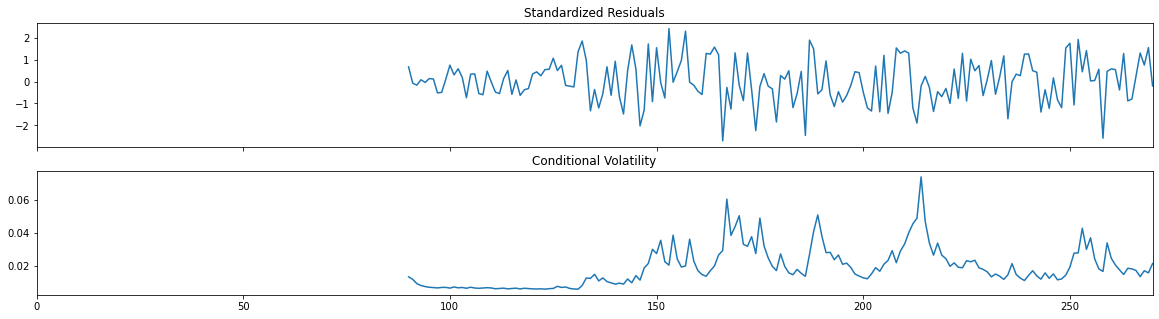

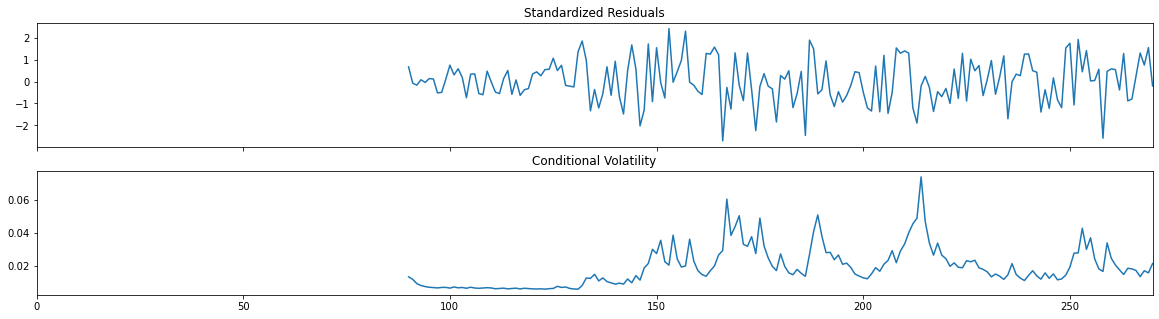

In [47]:
figarch_m.plot()

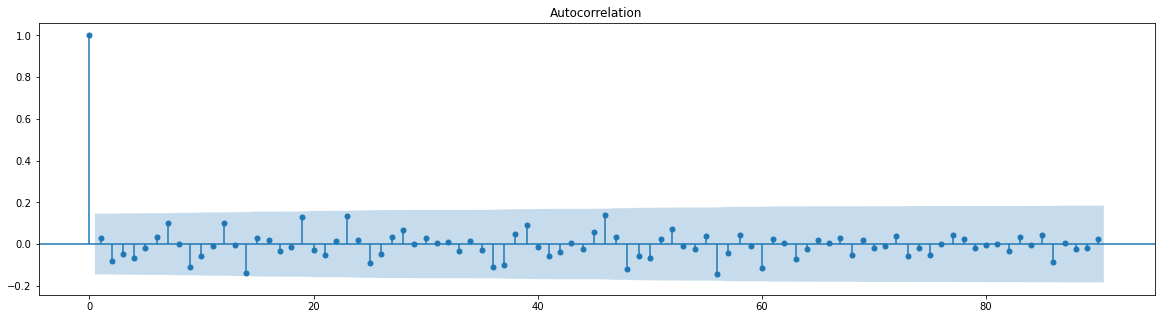

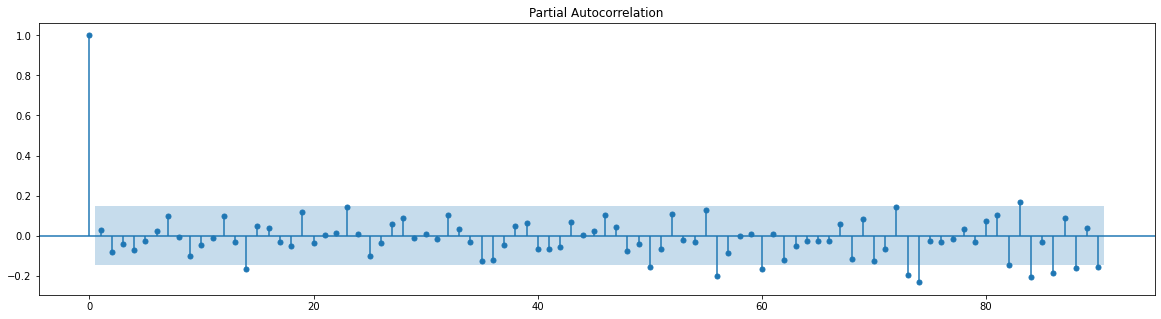

In [48]:
fig = sm.graphics.tsa.plot_acf(figarch_m.resid.dropna().values.squeeze(), lags=90)
fig1 = sm.graphics.tsa.plot_pacf(figarch_m.resid.dropna().values.squeeze(), lags=90)
plt.show()

In [52]:
egarch_m = arch_model(arima_res, mean='HARX', lags=100, vol='EGARCH', p=20, q=1)
egarch_m = egarch_m.fit(update_freq=0)
egarch_m.summary()

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00034. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration limit reached    (Exit mode 9)
            Current function value: -522.8826265056761
            Iterations: 100
            Function evaluations: 12708
            Gradient evaluations: 100


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:752: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


<class 'statsmodels.iolib.summary.Summary'>
"""
                          HAR - EGARCH Model Results                          
==============================================================================
Dep. Variable:                   None   R-squared:                       0.318
Mean Model:                       HAR   Adj. R-squared:                 -0.655
Vol Model:                     EGARCH   Log-Likelihood:                522.883
Distribution:                  Normal   AIC:                          -799.765
Method:            Maximum Likelihood   BIC:                          -413.341
                                        No. Observations:                  171
Date:                Mon, Mar 22 2021   Df Residuals:                       70
Time:                        12:41:15   Df Model:                          101
                                  Mean Model                                 
=============================================================================
                  coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------------------
Const       4.4217e-04  2.033e-06    217.487      0.000 [4.382e-04,4.462e-04]
None[0:1]       0.2703  6.809e-03     39.697      0.000     [  0.257,  0.284]
None[0:2]      -0.4350  2.193e-02    -19.835  1.473e-87     [ -0.478, -0.392]
None[0:3]       0.4917  7.888e-03     62.336      0.000     [  0.476,  0.507]
None[0:4]      -0.6630  2.951e-03   -224.658      0.000     [ -0.669, -0.657]
None[0:5]      -0.6805  8.091e-02     -8.410  4.100e-17     [ -0.839, -0.522]
None[0:6]       1.0417  1.082e-02     96.260      0.000     [  1.021,  1.063]
None[0:7]      -1.8835  4.639e-04  -4060.452      0.000     [ -1.884, -1.883]
None[0:8]       2.2246  1.180e-02    188.451      0.000     [  2.201,  2.248]
None[0:9]      -0.3559      0.246     -1.449      0.147     [ -0.837,  0.126]
None[0:10]     -0.3122      0.268     -1.165      0.244     [ -0.838,  0.213]
None[0:11]     -0.0401      0.186     -0.216      0.829     [ -0.404,  0.324]
None[0:12]      0.2462      0.223      1.103      0.270     [ -0.191,  0.684]
None[0:13]      3.3203      0.142     23.407 3.651e-121     [  3.042,  3.598]
None[0:14]     -1.6664      0.355     -4.696  2.648e-06     [ -2.362, -0.971]
None[0:15]      0.3385      0.235      1.440      0.150     [ -0.122,  0.799]
None[0:16]     -2.6312  4.596e-02    -57.246      0.000     [ -2.721, -2.541]
None[0:17]      1.1374      0.271      4.199  2.677e-05     [  0.607,  1.668]
None[0:18]     -2.7532      0.193    -14.229  6.072e-46     [ -3.132, -2.374]
None[0:19]     -1.5384      0.254     -6.045  1.493e-09     [ -2.037, -1.040]
None[0:20]      0.4050      0.438      0.924      0.356     [ -0.454,  1.264]
None[0:21]      1.2777      0.563      2.270  2.318e-02     [  0.175,  2.381]
None[0:22]      0.5851      0.459      1.274      0.203     [ -0.315,  1.485]
None[0:23]      3.6407  1.380e-02    263.912      0.000     [  3.614,  3.668]
None[0:24]     -3.3233  8.483e-02    -39.176      0.000     [ -3.490, -3.157]
None[0:25]      2.5176      0.488      5.163  2.427e-07     [  1.562,  3.473]
None[0:26]     -1.6502      0.248     -6.654  2.850e-11     [ -2.136, -1.164]
None[0:27]      2.1268      0.175     12.122  8.061e-34     [  1.783,  2.471]
None[0:28]     -0.8319      0.285     -2.915  3.556e-03     [ -1.391, -0.273]
None[0:29]     -1.6318      0.184     -8.860  7.986e-19     [ -1.993, -1.271]
None[0:30]      2.2808      0.225     10.140  3.666e-24     [  1.840,  2.722]
None[0:31]     -1.5170      0.359     -4.228  2.360e-05     [ -2.220, -0.814]
None[0:32]     -1.0533      0.270     -3.907  9.344e-05     [ -1.582, -0.525]
None[0:33]     -4.4640  1.845e-02   -241.926      0.000     [ -4.500, -4.428]
None[0:34]      6.0038  2.827e-02    212.364      0.000     [  5.948,  6.059]
None[0:35]     -1.5174      0.448     -3.384  7.144e-04     [ -2.396, -0.639]
None[0:36]      3.6851  4.947e-02     74.4

In [53]:
def eval_volatile_models(input_model):
    print ('AIC: ', input_model.aic)
    print ('BIC: ', input_model.bic)
    print ('R-squared: ', input_model.rsquared)
    print ('durbin_watson score: ', durbin_watson(input_model.resid.dropna()))

In [54]:
print('ARCH')
eval_volatile_models(arch_m)
print('GARCH')
eval_volatile_models(garch_m)
print('FIGARCH')
eval_volatile_models(figarch_m)
print('EGARCH')
eval_volatile_models(egarch_m)

ARCH
AIC:  -692.8304395137707
BIC:  -296.2168076368082
R-squared:  0.38708765966595404
durbin_watson score:  1.9866728303312968
GARCH
AIC:  -702.5651084058263
BIC:  -341.13494387278797
R-squared:  0.40421065345272245
durbin_watson score:  1.9830014428958733
FIGARCH
AIC:  -801.9290969601386
BIC:  -498.07187898988514
R-squared:  0.18367700825809818
durbin_watson score:  1.9380756980685492
EGARCH
AIC:  -799.7652530113521
BIC:  -413.3406355615249
R-squared:  0.31843004337357683
durbin_watson score:  1.9356206609336508


# Test pred

In [55]:
train_accum = list(y_true)
y_tru_val = list(y_tru_val)

In [ ]:
val_pred = []

for i in tqdm(range(len(y_tru_val))):
    model = ARIMA(train_accum, order=(40, 0, 44))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    val_pred.append(yhat)
    train_accum.append(yhat)
    print(f'predicted={yhat}, expected={y_tru_val[i]}')

  0%|          | 0/7 [00:00<?, ?it/s]/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 14%|█▍        | 1/7 [01:45<10:35, 105.98s/it]

predicted=-0.020812017946740428, expected=0.013685458126184713


In [36]:
y_tru_val

271    0.013685
272   -0.017165
273    0.067050
274   -0.073717
275    0.047814
276   -0.002428
277   -0.051877
Name: close, dtype: float64